## Assignment 1 : IMDB Sentiment Classification using MLP 
# The goal of this project is to build a MLP from scratch using NumPy to classify movie reviews as positive or negative using sentence-level polarity features.

## 1. Introduction & Setup

In [1]:
!pip install pandas numpy scikit-learn matplotlib vaderSentiment textblob

In [2]:
# =========================
# Imports
# =========================

# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Data splitting 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

# Text preprocessing
import re

# Sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob


In [3]:
import nltk
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\walid.000\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 2. Data Analysis & Correction

In [4]:

df = pd.read_csv("../data/IMDB Dataset.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (50000, 2)
Columns: ['review', 'sentiment']


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(418)

In [7]:
df = df.drop_duplicates().reset_index(drop=True)

print("New shape:", df.shape)

New shape: (49582, 2)


In [8]:
df["sentiment"].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [9]:

vader = SentimentIntensityAnalyzer()

def vader_score(text):
    return vader.polarity_scores(text)["compound"]

def textblob_score(text):
    return TextBlob(text).sentiment.polarity


## 3. Text pre-processing & classificiation

In [10]:

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["review_clean"] = df["review"].apply(clean_text)

df[["review", "review_clean"]].head()

,review,review_clean
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...","petter mattei's ""love in the time of money"" is..."


In [11]:
df["vader"] = df["review_clean"].apply(vader_score)
df["textblob"] = df["review_clean"].apply(textblob_score)

df[["review_clean", "vader", "textblob"]].head()


,review_clean,vader,textblob
0,one of the other reviewers has mentioned that ...,-0.9947,0.023433
1,a wonderful little production. the filming tec...,0.9641,0.109722
2,i thought this was a wonderful way to spend ti...,0.9780,0.360960
3,basically there's a family where a little boy ...,-0.8996,0.004167
4,"petter mattei's ""love in the time of money"" is...",0.9803,0.214483


In [12]:
df["label"] = df["sentiment"].map({
    "positive": 1,
    "negative": 0
})

df[["sentiment", "label"]].head()

,sentiment,label
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


## 4. Building Feature Matrices X & Y 

In [13]:

X = df[["vader", "textblob"]].to_numpy(dtype=np.float32)
y = df["sentiment"].map({"positive": 1, "negative": 0}).to_numpy(dtype=np.float32).reshape(-1, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (49582, 2)
y shape: (49582, 1)


## 5. Splitting Data

In [14]:
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Second split: 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (34707, 2)
Validation: (7437, 2)
Test: (7438, 2)


## 6. MLP Implementation

In [15]:
def relu(z):   # ReLU Activation function
    return np.maximum(0, z)

def relu_deriv(z): #used during back propagation to update weights
    return (z > 0).astype(np.float32)

def sigmoid(z): #Sigmoid function
    return 1 / (1 + np.exp(-z))

In [16]:
## Weight initialization
np.random.seed(42)

input_dim = 2
hidden_dim = 16
output_dim = 1

W1 = np.random.randn(input_dim, hidden_dim) * 0.5   # bigger init than 0.1
b1 = np.zeros((1, hidden_dim))

W2 = np.random.randn(hidden_dim, output_dim) * 0.5
b2 = np.zeros((1, output_dim))


In [17]:
def forward(X):
        # Linear transformation for hidden layer
    Z1 = X @ W1 + b1
     # Apply ReLU activation to introduce non-linearity
    A1 = relu(Z1)

    Z2 = A1 @ W2 + b2
    A2 = sigmoid(Z2) # Apply sigmoid to obtain probability predictions in (0, 1)

    cache = (X, Z1, A1, Z2, A2)     # Store values for use in backpropagation

    return A2, cache

In [18]:
def bce_loss(y_true, y_prob, eps=1e-7): # Small constant to prevent log(0), which is undefined
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

In [19]:
def backward(cache, y_true):
    X, Z1, A1, Z2, A2 = cache
    m = X.shape[0]

    dZ2 = (A2 - y_true)  # Gradient of loss w.r.t. output (sigmoid + BCE simplifies to A2 - y)
    dW2 = (A1.T @ dZ2) / m
    db2 = np.mean(dZ2, axis=0, keepdims=True) 

    dA1 = dZ2 @ W2.T     # Backpropagate error to hidden layer
    dZ1 = dA1 * relu_deriv(Z1)
    dW1 = (X.T @ dZ1) / m       # Gradients for first layer weights and biases
    db1 = np.mean(dZ1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2


In [20]:
def train_mlp_minibatch(X_train, y_train, X_val, y_val, epochs=300, lr=0.05, batch_size=64):
    global W1, b1, W2, b2
    n = X_train.shape[0]
    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        idx = np.random.permutation(n)
        Xs, ys = X_train[idx], y_train[idx]

        for start in range(0, n, batch_size):
            end = start + batch_size
            Xb, yb = Xs[start:end], ys[start:end]

            y_prob, cache = forward(Xb)
            dW1, db1_g, dW2, db2_g = backward(cache, yb)

            W1 -= lr * dW1
            b1 -= lr * db1_g
            W2 -= lr * dW2
            b2 -= lr * db2_g

        # track losses
        y_train_prob, _ = forward(X_train)
        y_val_prob, _ = forward(X_val)

        tr_loss = bce_loss(y_train, y_train_prob)
        va_loss = bce_loss(y_val, y_val_prob)

        train_losses.append(tr_loss)
        val_losses.append(va_loss)

        if epoch % 50 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | Train loss {tr_loss:.4f} | Val loss {va_loss:.4f}")

    return train_losses, val_losses


## 7. Model Training

In [21]:

train_losses, val_losses = train_mlp_minibatch(
    X_train, y_train, X_val, y_val,
    epochs=300, lr=0.05, batch_size=64
)

# The loss drops quickly during the first 50 epochs, which shows that the model is learning early on.
# After around 100 epochs, both training and validation losses stabilize and change only slightly.
# The two values stay close to each other throughout training, suggesting that the model is not overfitting. 
# Beyond 150 epochs, improvements are very small

Epoch 001 | Train loss 0.5260 | Val loss 0.5307
Epoch 050 | Train loss 0.4751 | Val loss 0.4809
Epoch 100 | Train loss 0.4722 | Val loss 0.4778
Epoch 150 | Train loss 0.4727 | Val loss 0.4783
Epoch 200 | Train loss 0.4728 | Val loss 0.4783
Epoch 250 | Train loss 0.4717 | Val loss 0.4772
Epoch 300 | Train loss 0.4715 | Val loss 0.4772


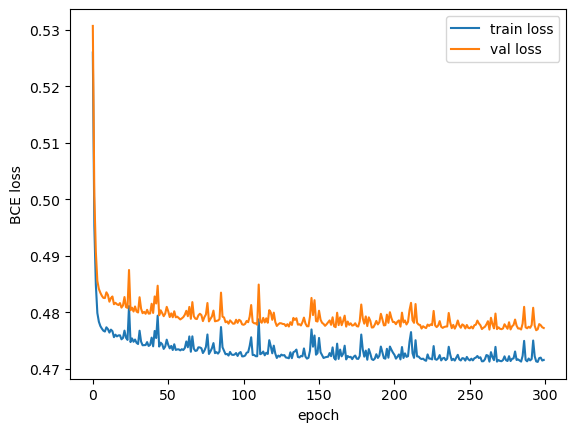

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("BCE loss")
plt.legend()
plt.show()

# The loss curves show a sharp decrease during the initial epochs, followed by gradual stabilization.
# Both training and validation losses decrease consistently and remain close, 
# indicating stable convergence and minimal overfitting. After approximately 100–150 epochs,
# the model reaches a plateau, suggesting that additional training yields diminishing improvements.
# Overall, the behavior reflects effective learning and good performance.

## 8. Evaluations

In [23]:
y_prob_val, _ = forward(X_val)
print("min prob:", float(y_prob_val.min()))
print("max prob:", float(y_prob_val.max()))
print("mean prob:", float(y_prob_val.mean()))

# The predicted probabilities range from very close to 0 up to nearly 1, with an average around 0.5.
# It shows us that the model is confident in many of its predictions and has not collapsed to predicting a constant value such as 0.5. 


min prob: 0.00013026926160086957
max prob: 0.9994462341998951
mean prob: 0.5126961544324742


In [24]:
def predict(X, threshold=0.5):
    probs, _ = forward(X)
    return (probs >= threshold).astype(int), probs

# Validation
y_val_pred, _ = predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

# Test
y_test_pred, _ = predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)

print("Val accuracy:", val_acc)
print("Test accuracy:", test_acc)
print("Confusion matrix:\n", cm)


Val accuracy: 0.7692617991125453
Test accuracy: 0.7718472707717128
Confusion matrix:
 [[2801  904]
 [ 793 2940]]


## 9. Saved Results

In [25]:
import os
os.makedirs("../results", exist_ok=True)

plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("BCE loss")
plt.legend()
plt.savefig("../results/loss_curves.png")
plt.close()

print("Saved: results/loss_curves.png")


Saved: results/loss_curves.png


In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig("../results/confusion_matrix.png")
plt.close()

print("Saved: results/confusion_matrix.png")


Saved: results/confusion_matrix.png


In [28]:
with open("../results/metrics.txt", "w") as f:
    f.write(f"Validation Accuracy: {val_acc}\n")
    f.write(f"Test Accuracy: {test_acc}\n\n")
    f.write("Confusion Matrix:\n")
    f.write(str(cm))

print("Saved: results/metrics.txt")


Saved: results/metrics.txt


In [29]:
# Predict for all data rows
y_all_pred, _ = predict(X)

submission = df[["review"]].copy()
submission["prediction"] = y_all_pred.astype(int)

submission.to_csv("../submission.csv", index=False)
print("Saved: submission.csv")


Saved: submission.csv


### Final Results Analysis & Conclusion

In [30]:
import os

os.makedirs("../results", exist_ok=True)

discussion = f"""


1. Objective

The objective of this assignment was to build a Multi-Layer Perceptron (MLP) from scratch using NumPy
to classify IMDB movie reviews as either positive or negative.

The process followed a clear pipeline: cleaning the text, extracting sentence-level sentiment features,
encoding labels, splitting the data into training/validation/test sets, and training the neural network
using mini-batch gradient descent.

2. Model Setup

Each review was represented using only two numerical features:
- VADER compound polarity score
- TextBlob polarity score

The neural network consisted of:
- 2 input features
- 1 hidden layer with 16 ReLU neurons
- 1 sigmoid output neuron
- Binary Cross-Entropy loss
- Mini-batch gradient descent (learning rate = 0.05)

3. Training Behavior

The loss decreased sharply in the first few epochs, showing that the model quickly learned useful
patterns from the data. After roughly 100–150 epochs, both training and validation losses stabilized,
indicating convergence.

Importantly, the training and validation curves remained close to each other throughout training,
suggesting that the model did not significantly overfit.

4. Performance

Validation Accuracy: {val_acc:.4f}
Test Accuracy: {test_acc:.4f}

Confusion Matrix (Test Set):
{cm}

The validation and test accuracies are very similar, which indicates good generalization.
The confusion matrix shows that the model performs fairly evenly across both classes,
with comparable numbers of false positives and false negatives.

5. Interpretation and Limitations

Achieving around 77% test accuracy using only two sentence-level polarity features is a strong result.
However, polarity-based methods have limitations. They may struggle with sarcasm, negation,
and reviews that contain mixed sentiment where positive and negative wording offsets each other.

6. Conclusion

Overall, this experiment demonstrates that even simple lexicon-based sentiment features can provide
meaningful predictive power when combined with a properly implemented neural network.
Despite its simplicity, the MLP achieved stable learning and solid generalization performance.
"""

with open("../results/results_discussion.txt", "w", encoding="utf-8") as f:
    f.write(discussion)

print("Saved: ../results/results_discussion.txt")


Saved: ../results/results_discussion.txt


In [31]:
## Save Model
import pickle, os

os.makedirs("../model", exist_ok=True)

model_params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

with open("../model/best_model.pkl", "wb") as f:
    pickle.dump(model_params, f)

print("Saved: model/best_model.pkl")


Saved: model/best_model.pkl


In [32]:

os.makedirs("../results", exist_ok=True)

plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("BCE loss")
plt.legend()
plt.savefig("../results/loss_curves.png")
plt.close()

print("Saved: results/loss_curves.png")


Saved: results/loss_curves.png
